In [1]:
import torch
from torchvision.models.vgg import vgg16_bn

# Charger le modèle pré-entraîné
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = vgg16_bn(pretrained=True).to(device)
model.eval()

# Explorer les couches convolutives
conv_layers = [name for name, layer in model.features.named_children() if isinstance(layer, torch.nn.Conv2d)]

# Obtenir le nombre de features (filtres) par couche
feature_counts = {f"features.{idx}": layer.out_channels for idx, layer in enumerate(model.features) if isinstance(layer, torch.nn.Conv2d)}

print("Couches convolutives disponibles:", conv_layers)
print("Nombre de features par couche:", feature_counts)


D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Couches convolutives disponibles: ['0', '3', '7', '10', '14', '17', '20', '24', '27', '30', '34', '37', '40']
Nombre de features par couche: {'features.0': 64, 'features.3': 64, 'features.7': 128, 'features.10': 128, 'features.14': 256, 'features.17': 256, 'features.20': 256, 'features.24': 512, 'features.27': 512, 'features.30': 512, 'features.34': 512, 'features.37': 512, 'features.40': 512}


In [2]:
for i, layer in enumerate(model.features):
    print(f"features.{i}: {layer}")


features.0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.1: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
features.2: ReLU(inplace=True)
features.3: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.4: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
features.5: ReLU(inplace=True)
features.6: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
features.7: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.8: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
features.9: ReLU(inplace=True)
features.10: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.11: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
features.12: ReLU(inplace=True)
features.13: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
features.14: C

In [3]:
import torch
import torchvision.transforms as T
from torchvision.models.vgg import vgg16_bn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Importer ZennitCRP
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.helper import get_layer_names
from crp.concepts import ChannelConcept

In [4]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = vgg16_bn(True).to(device)
model.eval()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
image_path = "data/lizard.jpg"
#image_path = "data/n01843383_180.jpeg"

In [6]:
#image = Image.open(image_path)
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

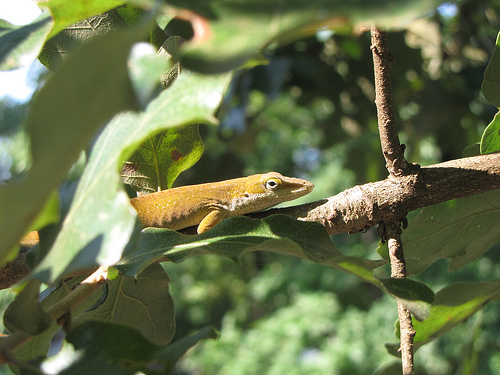

In [7]:
image

In [8]:
output = model(input_tensor)
pred_class = torch.argmax(output, dim=1).item()
print(f"Classe prédite: {pred_class}")
probs = torch.nn.functional.softmax(output, dim=1)
print(f"Probabilités: {probs[0, pred_class]}")

Classe prédite: 40


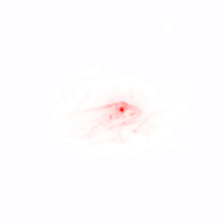

In [9]:
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.helper import get_layer_names
from crp.image import imgify

composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)

input_tensor.requires_grad = True

In [11]:
def zero_out_feature(module, input, output):
    output[:, 89, :, :] = 0  # Désactiver la feature 89
    return output

# Ajouter le hook
hook = model.features[40].register_forward_hook(zero_out_feature)

# Faire une prédiction avec la feature désactivée
output_disabled = model(input_tensor)
probs_disabled = torch.nn.functional.softmax(output_disabled, dim=1)

# Supprimer le hook
hook.remove()

# Comparer avec la prédiction originale
output_original = model(input_tensor)
probs_original = torch.nn.functional.softmax(output_original, dim=1)

# Calcul de l'importance
importance = probs_original[0, pred_class] - probs_disabled[0, pred_class]
print(f"Importance de la feature 89: {importance:.4f}")


Importance de la feature 89: -0.0014


In [12]:
import torch
from torchvision.models.vgg import vgg16_bn

def compute_feature_importance(model, input_tensor, layer_idx, num_features, pred_class):
    """
    Calcule l'importance de chaque feature d'une couche donnée pour une classe prédite.

    Arguments :
    - model : le modèle VGG16
    - input_tensor : l'image d'entrée sous forme de tenseur
    - layer_idx : l'index de la couche (ex : 40)
    - num_features : le nombre total de features dans cette couche (ex : 512)
    - pred_class : la classe prédite initialement

    Retourne :
    - Un dictionnaire {feature_idx : importance} trié par importance décroissante
    """

    # Obtenir la probabilité originale de la classe prédite
    with torch.no_grad():
        output_original = model(input_tensor)
        probs_original = torch.nn.functional.softmax(output_original, dim=1)
        original_score = probs_original[0, pred_class].item()

    feature_importance = {}

    # Désactiver chaque feature une par une et mesurer l'impact
    for feature_idx in range(num_features):
        def zero_out_feature(module, input, output, feature_idx=feature_idx):
            output[:, feature_idx, :, :] = 0  # Désactiver la feature
            return output

        # Ajouter un hook temporaire
        hook = model.features[layer_idx].register_forward_hook(zero_out_feature)

        # Faire une prédiction avec la feature désactivée
        with torch.no_grad():
            output_disabled = model(input_tensor)
            probs_disabled = torch.nn.functional.softmax(output_disabled, dim=1)
            new_score = probs_disabled[0, pred_class].item()

        # Supprimer le hook
        hook.remove()

        # Calcul de l'importance
        importance = original_score - new_score
        feature_importance[feature_idx] = importance

        # Affichage de progression
        print(f"Feature {feature_idx+1}/{num_features} - Importance: {importance:.4f}")

    # Trier les features par importance décroissante
    sorted_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))

    return sorted_importance


In [16]:
# Charger le modèle
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = vgg16_bn(pretrained=True).to(device)
model.eval()

# Charger une image
import torchvision.transforms as T
from PIL import Image

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

image = Image.open("data/lizard.jpg")
input_tensor = transform(image).unsqueeze(0).to(device)

# Prédire la classe initiale
with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()

# Lancer l'analyse sur la couche 40 (512 features)
importance_dict = compute_feature_importance(model, input_tensor, layer_idx=40, num_features=512, pred_class=pred_class)

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature 0/512 - Importance: 0.0091
Feature 1/512 - Importance: -0.0035
Feature 2/512 - Importance: 0.0079
Feature 3/512 - Importance: -0.0087
Feature 4/512 - Importance: 0.0045
Feature 5/512 - Importance: -0.0005
Feature 6/512 - Importance: -0.0026
Feature 7/512 - Importance: 0.0198
Feature 8/512 - Importance: -0.0014
Feature 9/512 - Importance: -0.0064
Feature 10/512 - Importance: 0.0144
Feature 11/512 - Importance: 0.0049
Feature 12/512 - Importance: 0.0038
Feature 13/512 - Importance: 0.0005
Feature 14/512 - Importance: 0.0062
Feature 15/512 - Importance: 0.0031
Feature 16/512 - Importance: -0.0040
Feature 17/512 - Importance: -0.0012
Feature 18/512 - Importance: -0.0007
Feature 19/512 - Importance: 0.0177
Feature 20/512 - Importance: 0.0009
Feature 21/512 - Importance: -0.0060
Feature 22/512 - Importance: 0.0048
Feature 23/512 - Importance: -0.0040
Feature 24/512 - Importance: 0.0093
Feature 25/512 - Importance: -0.0035
Feature 26/512 - Importance: -0.0006
Feature 27/512 - Importan

In [13]:
import matplotlib.pyplot as plt
import numpy as np

input_tensor.requires_grad = True
batch = 8
num_features = 512
features_per_row = 8  # 8 images par ligne
num_feature_per_batch = int(num_features / batch)
all_conditions = []
all_heatmaps = []
for i in range(batch):

    # Initialisation des conditions et de l'attribution
    conditions = [{"y": [40], "features.40": [i]} for i in range(i*num_feature_per_batch, (i+1)*num_feature_per_batch)]
    all_conditions.append(conditions)
    heatmaps, _, _, _ = attribution(input_tensor, conditions, composite)
    all_heatmaps.append(heatmaps)

In [14]:
heatmaps = np.concatenate(all_heatmaps, axis=0)

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\zennit\image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)


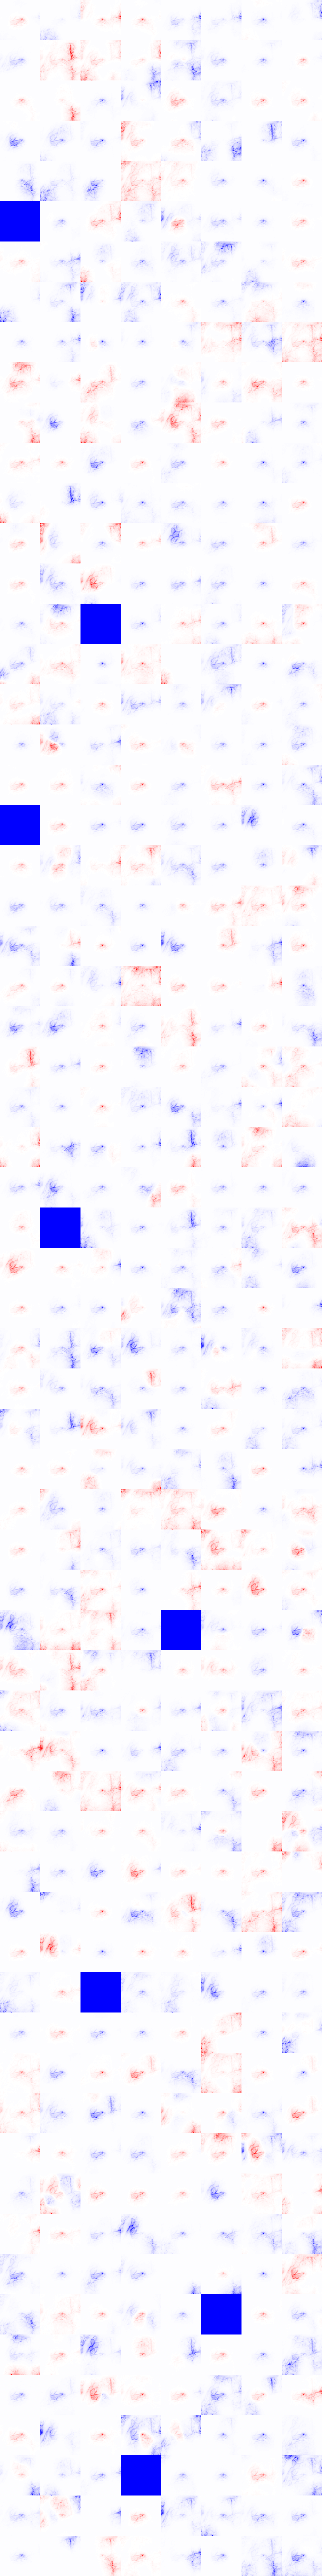

In [15]:
imgify(heatmaps, symmetric=True, grid=(num_features // features_per_row, features_per_row))

In [20]:
number_top_features = 10

In [17]:
# Afficher les 10 features les plus importantes
print(f"\nTop {number_top_features} features les plus importantes :")
bestFeatures = []
for feature, importance in list(importance_dict.items())[:number_top_features]:
    bestFeatures.append(feature)
    print(f"Feature {feature}: Importance {importance:.4f}")


Top 10 features les plus importantes :
Feature 469: Importance 0.2639
Feature 409: Importance 0.0683
Feature 287: Importance 0.0680
Feature 59: Importance 0.0646
Feature 200: Importance 0.0608
Feature 339: Importance 0.0529
Feature 495: Importance 0.0523
Feature 150: Importance 0.0497
Feature 489: Importance 0.0444
Feature 466: Importance 0.0423


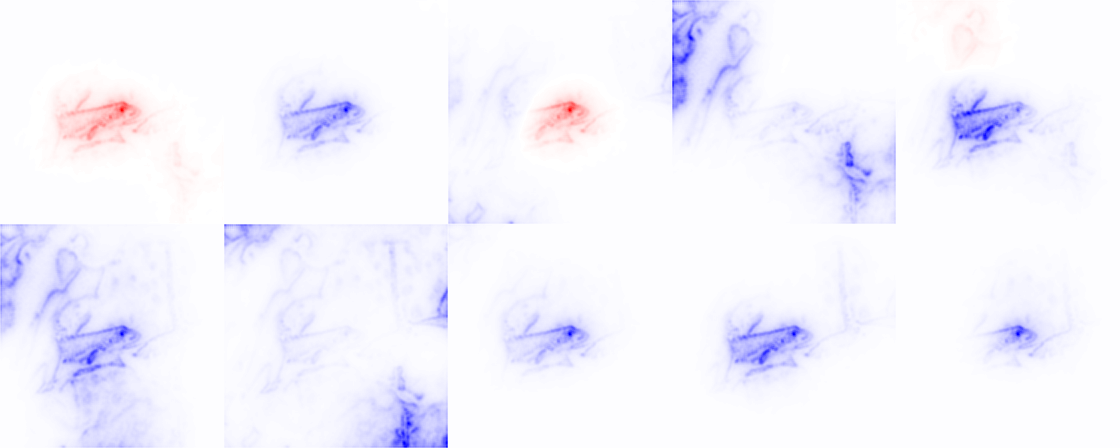

In [21]:
input_tensor.requires_grad = True
num_features = number_top_features
features_per_row = 5
conditions = [{"y": [40], "features.40": [i]} for i in bestFeatures]
heatmaps, _, _, _ = attribution(input_tensor, conditions, composite)
imgify(heatmaps, symmetric=True, grid=(num_features // features_per_row, features_per_row))

In [18]:
# Afficher les 10 features les moins importantes
worstFeatures = []
print(f"\nTop {number_top_features} features les moins importantes :")
for feature, importance in list(importance_dict.items())[-number_top_features:]:
    worstFeatures.append(feature)
    print(f"Feature {feature}: Importance {importance:.4f}")


Top 10 features les moins importantes :
Feature 318: Importance -0.0214
Feature 457: Importance -0.0218
Feature 121: Importance -0.0244
Feature 408: Importance -0.0293
Feature 42: Importance -0.0295
Feature 241: Importance -0.0308
Feature 195: Importance -0.0369
Feature 249: Importance -0.0465
Feature 71: Importance -0.0477
Feature 155: Importance -0.0590


D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\zennit\image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)


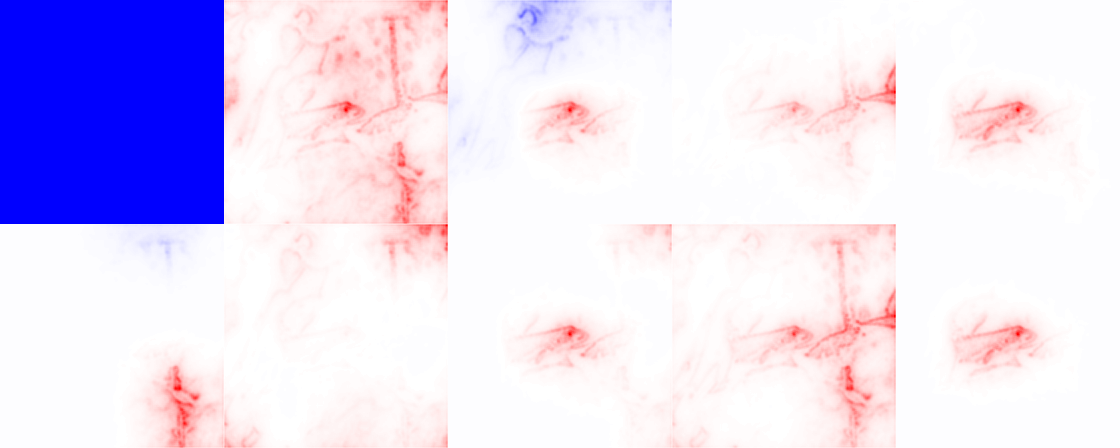

In [22]:
input_tensor.requires_grad = True
num_features = number_top_features
features_per_row = 5
conditions = [{"y": [40], "features.40": [i]} for i in worstFeatures]
heatmaps, _, _, _ = attribution(input_tensor, conditions, composite)
imgify(heatmaps, symmetric=True, grid=(num_features // features_per_row, features_per_row))